In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from PIL import ImageOps
import tensorflow_datasets as tfds

In [ ]:
training_data, training_metadata = tfds.load(
  "Food101",
  split = "train",
  shuffle_files = True,
  as_supervised = True,
  batch_size = 128,
  with_info = True
)

validation_data, validation_metadata = tfds.load(
  "Food101",
  split = "validation",
  shuffle_files = True,
  as_supervised = True,
  batch_size = 128,
  with_info = True
)

In [9]:
training_metadata.features["label"].num_classes, training_metadata.features["label"].names

(101,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  

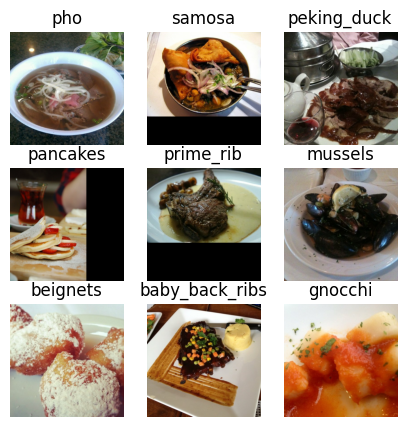

In [12]:
classes = training_metadata.features["label"].names
sample_data = list(training_data.take(1))

plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # convert image to array of uint
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

In [14]:
from tqdm import tqdm

In [15]:
data = {
  class_name: 0
  for class_name in classes
}

In [17]:
for _, label in tqdm(training_data):
  for value in label:
    class_id = int(value)
    # class_name = classes[class_id]
    class_name = training_metadata.features["label"].int2str(class_id)

    data[class_name] += 1

100%|██████████| 592/592 [01:36<00:00,  6.15it/s]


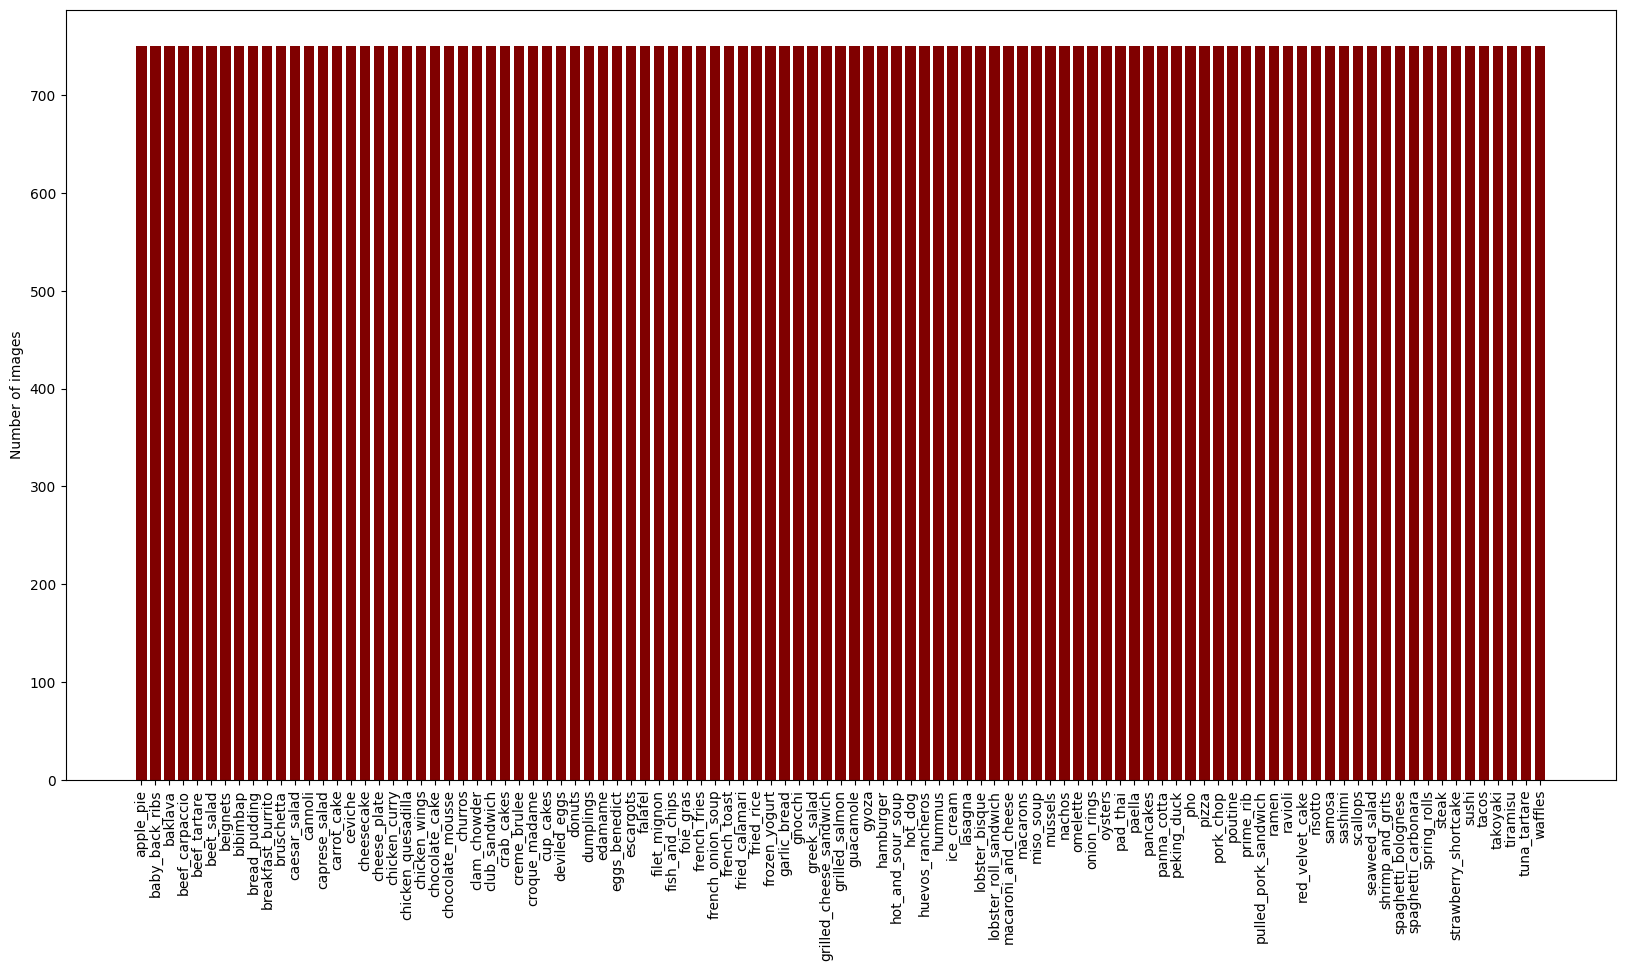

In [22]:
meals = list(data.keys())
images_count = list(data.values())

figure = plt.figure(figsize = (20, 10))

plt.bar(meals, images_count, color = "maroon", width = 0.75)
plt.xticks(range(len(meals)), meals, rotation = "vertical")
plt.ylabel("Number of images")
plt.show()

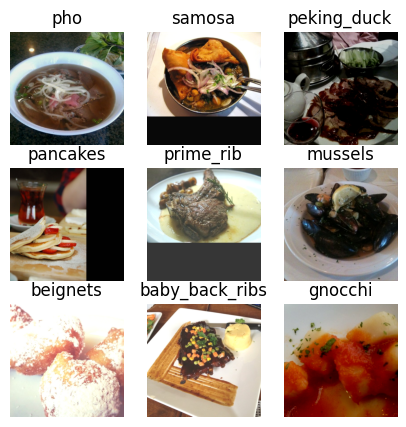

In [23]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # uint8 = 0 - 255
    img = layers.RandomBrightness(factor = 0.3, value_range = (0, 255))(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

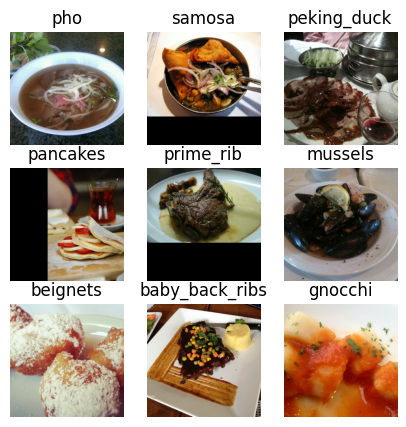

In [24]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    img = layers.RandomFlip("horizontal")(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

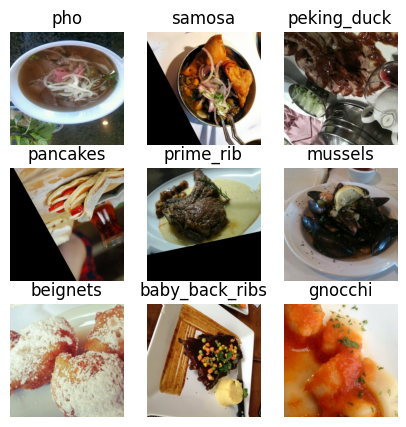

In [25]:
plt.figure(figsize = (5, 5))

for images, labels in sample_data:
  # draw first 9 images
  for i in range(9):
    axes = plt.subplot(3, 3, i + 1)
    # 0.5 random rotates between -90 and +90 deg
    img = layers.RandomRotation(0.5)(images[i])
    img = img.numpy().astype("uint8")
    plt.imshow(img)
    plt.title(classes[int(labels[i])])
    plt.axis("off")

In [26]:
IMAGE_SIZE = (256, 256)

resize_layer = layers.Resizing(*IMAGE_SIZE)

training_data = training_data.map(
  lambda image, label: (resize_layer(image), label),
  # allow parallel processing of images
  num_parallel_calls = tf.data.AUTOTUNE
)

validation_data = validation_data.map(
  lambda image, label: (resize_layer(image), label),
  # allow parallel processing of images
  num_parallel_calls = tf.data.AUTOTUNE
)

In [27]:
augmented_data = keras.Sequential(
  [
    layers.RandomBrightness(factor = 0.3, value_range = (0, 255)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.5),
  ]
)

training_data = training_data.map(
  lambda image, label: (augmented_data(image), label),
  # allow parallel processing of images
  num_parallel_calls = tf.data.AUTOTUNE
)

In [34]:
L1_LAMBDA = 1e-4
L2_LAMBDA = 1e-4

def make_model(input_shape, num_classes):
  inputs = keras.Input(shape = input_shape)

  # 255 is the largest possible value
  x = layers.Rescaling(1.0 / 255)(inputs)

  backbone = tf.keras.applications.InceptionV3(
    # InceptionV3 predict 1000 classes, but we need 101 classes, so we need to remove the output layer
    include_top = False,
    # InceptionV3 was trained on imagenet
    weights = "imagenet"
  )

  x = backbone(x)

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.5)(x)
  
  x = layers.Dense(256, activation = "relu", kernel_regularizer = regularizers.L1(L1_LAMBDA), activity_regularizer = regularizers.L2(L2_LAMBDA))(x)
  x = layers.Dropout(0.5)(x)
  
  outputs = layers.Dense(num_classes, activation = "softmax")(x)

  return keras.Model(inputs, outputs)


In [35]:
# each pixel has 3 color
IMAGE_SIZE = (256, 256) + (3, )

model = make_model(input_shape = IMAGE_SIZE, num_classes = 101)

In [41]:
# learning rate = 0.001

model.compile(
  optimizer = keras.optimizers.Adam(1e-3), 
  loss = "sparse_categorical_crossentropy",
  metrics = ["accuracy"]
)

Continue training from the last epoch if stopped for some reason

In [37]:
# model = tf.keras.models.load_model("04-dumps/epoch-{epoch}.keras")

epochs = 7

callbacks = [
  keras.callbacks.ModelCheckpoint("04-dumps/epoch-{epoch}.keras")
]

model_output = model.fit(
  training_data,
  epochs = epochs,
  callbacks = callbacks,
  validation_data = validation_data
)

In [ ]:
import json

# 1 is the number of training batch, each 7 epochs are 1 training batches
json.dump(model_output.history, open("04-dumps/history-1.json", "w"))

In [ ]:
history = {
  "loss": [],
  "accuracy": [],
  "val_loss": [],
  "val_accuracy": []
}

# 6 training batches
for i in range(1, 7):
  file_path = f"04-dumps/history-{i}.json"

  with open(file_path) as f:
    data = json.loads(f.read())

  for key in history:
    history[key].extend(data[key])

In [ ]:
plt.plot(model_output.history["accuracy"], label = "Train")
plt.plot(model_output.history["val_accuracy"], label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
plt.plot(model_output.history["loss"], label = "Train")
plt.plot(model_output.history["val_loss"], label = "Validation")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
loaded_model = keras.models.load_model("dumps/epoch-42.keras")

In [ ]:
plt.figure(figsize = (21, 21))

for images, labels in validation_data.take(1):
  for i in range(36):
    axes = plt.subplot(6, 6, i + 1)
    img = images[i].numpy().astype("uint8")
    plt.imshow(img)
    img_array = tf.expand_dims(img, 0)
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    plt.title(classes[predicted_class])
    plt.axis("off")